# Levenshtein distance

### 1. Load corpus from previous lab exercises

In [1]:
from datasets import load_dataset

fiqa_corpus = load_dataset("clarin-knext/fiqa-pl", "corpus")["corpus"]
fiqa_queries = load_dataset("clarin-knext/fiqa-pl", "queries")["queries"]
fiqa_qa = load_dataset("clarin-knext/fiqa-pl-qrels")["test"]

### 2. Tokenize the documents using pyspark
### 3. Compute frequency list for each file

In [2]:
from spacy.lang.pl import Polish

nlp = Polish()
tokenizer = nlp.tokenizer

In [3]:
from tqdm import tqdm

unique_keys = set()
all_freq_lists = []
for txt in tqdm(fiqa_corpus["text"]):
    freq_list = {}
    for word in tokenizer(txt):
        if word.text not in freq_list:
            freq_list[word.text] = 0
        freq_list[word.text] += 1
    all_freq_lists.append(freq_list)

100%|██████████| 57638/57638 [00:50<00:00, 1133.26it/s]


### 4. Aggregate the result to obtain one global frequency list.

In [4]:
combined_freq_list = {}

for freq_list in tqdm(all_freq_lists):
    for word, count in freq_list.items():
        if word not in combined_freq_list:
            combined_freq_list[word] = 0
        combined_freq_list[word] += count

100%|██████████| 57638/57638 [00:01<00:00, 38582.18it/s]


Convert to list

In [5]:
full_frequency_list = sorted(
    [(key, val) for key, val in combined_freq_list.items()], key=lambda x: x[1]
)[::-1]

In [6]:
import string

# remove punctuation
punc_list = list(string.punctuation)
full_frequency_list = [l for l in full_frequency_list if l[0] not in punc_list]
full_frequency_list[:10]

[('w', 158679),
 ('i', 123752),
 ('na', 114440),
 ('nie', 112694),
 ('to', 100506),
 ('z', 93299),
 ('że', 89943),
 ('jest', 88956),
 ('się', 85809),
 ('do', 65866)]

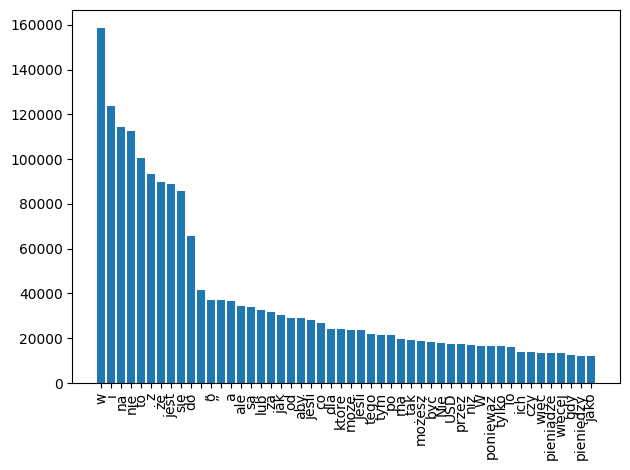

In [7]:
import matplotlib.pyplot as plt

words = [word for word, count in full_frequency_list[:50]]
counts = [count for word, count in full_frequency_list[:50]]

plt.xticks(rotation="vertical")
plt.bar(words, counts)
plt.tight_layout()
plt.show()

### 5. Distort queries

In [8]:
import random


def distort_text(text):
    words = text.split()

    word_idx = random.randint(0, len(words) - 1)
    old_word = words[word_idx]
    char_index = random.randint(0, len(old_word) - 1)

    new_char = random.choice(string.ascii_lowercase.replace(old_word[char_index], ""))
    new_word = old_word[:char_index] + new_char + old_word[char_index + 1 :]
    words[word_idx] = new_word

    return " ".join(words)

In [9]:
distort_text("zalewam jerbę monsterem")

'zalewam jerxę monsterem'

In [10]:
# create map query id -> query text
query_map = {int(idx): q for idx, q in zip(fiqa_queries["_id"], fiqa_queries["text"])}

# create map query id -> distorted query text
query_map_distorted = {}
for idx, q in zip(fiqa_queries["_id"], fiqa_queries["text"]):
    q_dist = distort_text(q)
    query_map_distorted[int(idx)] = q_dist

### 6. Compute NDCG@10 for new queries

In [11]:
# create map query id -> relevant corpus ids
query_corpus_map = {}
for query_id, corpus_id in zip(fiqa_qa["query-id"], fiqa_qa["corpus-id"]):
    if query_id not in query_corpus_map:
        query_corpus_map[query_id] = []
    query_corpus_map[query_id].append(corpus_id)

This is where you should create your elasticsearch process

In [12]:
!curl -X DELETE "localhost:9200/pol"
!curl -X DELETE "localhost:9200/pol_without_lemmatizer"

{"acknowledged":true}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    21  100    21    0     0    440      0 --:--:-- --:--:-- --:--:--   446


{"error":{"root_cause":[{"type":"index_not_found_exception","reason":"no such index [pol_without_lemmatizer]","resource.type":"index_or_alias","resource.id":"pol_without_lemmatizer","index_uuid":"_na_","index":"pol_without_lemmatizer"}],"type":"index_not_found_exception","reason":"no such index [pol_without_lemmatizer]","resource.type":"index_or_alias","resource.id":"pol_without_lemmatizer","index_uuid":"_na_","index":"pol_without_lemmatizer"},"status":404}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   461  100   461    0     0   261k      0 --:--:-- --:--:-- --:--:--  450k


In [13]:
import requests
import json

bulk_url = "http://localhost:9200/pol/_bulk"
elasticsearch_headers = {"Content-Type": "application/json"}

# create data index
data = []
for _id, text in zip(fiqa_corpus["_id"], fiqa_corpus["text"]):
    id_head = json.dumps(
        {"index": {"_index": "pol", "_id": str(_id)}}, ensure_ascii=False
    )
    content = json.dumps({"text": text}, ensure_ascii=False)
    data.append(id_head)
    data.append(content)

# join the bul data
bulk_data = "\n".join([item for item in data]) + "\n"

response = requests.post(
    bulk_url, headers=elasticsearch_headers, data=bulk_data.encode("utf-8")
)

print(response.status_code)
print(response.json()["errors"])

200
False


In [14]:
synonym_list = [
    "kwiecień, kwi, IV",
    "styczeń, sty, I",
    "luty, lut, II",
    "marzec, mar, III",
    "maj, V",
    "czerwiec, cze, VI",
    "lipiec, lip, VII",
    "sierpień, sie, VIII",
    "wrzesień, wrz, IX",
    "październik, paź, X",
    "listopad, lis, XI",
    "grudzień, gru, XII",
]

In [15]:
analyzer_settings = {
    "settings": {
        "analysis": {
            "filter": {
                "polish_synonym": {
                    "type": "synonym",
                    "synonyms": synonym_list,
                }
            },
            "analyzer": {
                "polish": {
                    "tokenizer": "standard",
                    "filter": [
                        "lowercase",
                        "polish_synonym",
                        "morfologik_stem",
                        "lowercase",
                    ],
                },
            },
        }
    },
    "mappings": {
        "properties": {
            "text": {
                "type": "text",
                "analyzer": "polish",
                "fields": {"keyword": {"type": "keyword"}},
            },
        }
    },
}

In [16]:
elastic_url = "http://localhost:9200/pol"

# send the analyzer settings and mappings to elasticsearch
response = requests.put(
    elastic_url,
    headers=elasticsearch_headers,
    data=json.dumps(analyzer_settings),
)

response.json()

{'error': {'root_cause': [{'type': 'resource_already_exists_exception',
    'reason': 'index [pol/Uz0SzAtLTgavAsLBG6wpCQ] already exists',
    'index_uuid': 'Uz0SzAtLTgavAsLBG6wpCQ',
    'index': 'pol'}],
  'type': 'resource_already_exists_exception',
  'reason': 'index [pol/Uz0SzAtLTgavAsLBG6wpCQ] already exists',
  'index_uuid': 'Uz0SzAtLTgavAsLBG6wpCQ',
  'index': 'pol'},
 'status': 400}

In [17]:
import numpy as np


def ndcg_at_k(query_map, k, search_url, fuzzy=False, corpus_map=query_corpus_map):
    # create logarithm vector to avoid unnecessary computations later
    logs = np.log2(np.arange(2, 2 + k))

    # iterate over all queries to compute ndcg for each of them
    ndcg_list = []

    query_dict = {"query": {"match": {"text": {}}}, "size": k}

    if fuzzy:
        query_dict["query"]["match"]["text"]["fuzziness"] = "AUTO"

    for query_id, corpus_id_list in corpus_map.items():
        query_text = query_map[query_id]

        query_dict["query"]["match"]["text"]["query"] = query_text

        query_request = json.dumps(query_dict)
        response = requests.post(
            search_url, headers=elasticsearch_headers, data=query_request
        )
        data = response.json()
        hits = [int(h["_id"]) for h in data["hits"]["hits"]]

        # sometimes the list of correct matches is shorter than k
        # in  those cases we pad with 0s
        idcg = [1 if i < len(corpus_id_list) else 0 for i in range(k)]
        dcg = [1 if h in corpus_id_list else 0 for h in hits]

        idcg = np.array(idcg) / logs
        dcg = np.array(dcg) / logs

        ndcg_list.append(dcg.sum() / idcg.sum())

    return np.mean(ndcg_list)

In [18]:
ndcg_at_k(query_map, 10, "http://localhost:9200/pol/_search?pretty")

0.12903476818367676

In [19]:
ndcg_at_k(query_map_distorted, 10, "http://localhost:9200/pol/_search?pretty")

0.13650240200202593

### 7. Use Morfeusz to detect incorrect words
### 8. Use Levenshtein distance to find the best matching word
### 9. Compute NDCG@10 for the resulting queries

This kind of distribution is desribed by Zipf's law. The distribution seems to be following the trend of harmonic series or 1/x function 

In [20]:
from Levenshtein import distance


# greedy algorithm that searches for the most popular word in corpus with levenstein distance equal to 1 or 0
def correct_word(word):
    best_word = word
    min_dist = float("inf")

    for current_word, _ in full_frequency_list:
        dist = distance(current_word, word)
        if (
            dist < 2
        ):  # include words from the original that were not recognized by morfologik
            return current_word
        if dist < min_dist:
            min_dist = dist
            best_word = current_word

    return best_word

In [21]:
correct_word("korowód")

'rodowód'

In [22]:
import morfeusz2
from time import time

start = time()

morf = morfeusz2.Morfeusz()

query_map_corrected = {}

for idx, q in tqdm(query_map_distorted.items()):
    analyzed_text = morf.analyse(q)
    text_list = []

    for analysis in analyzed_text:
        if analysis[0] < len(text_list):
            continue
        word = analysis[2][0]
        if analysis[2][2] == "ign":
            word = correct_word(word)
        text_list.append(word)

    text = " ".join(text_list)

    query_map_corrected[idx] = text

ndcg_result = ndcg_at_k(
    query_map_corrected, 10, "http://localhost:9200/pol/_search?pretty"
)

end = time()

print(f"full time : {round(end-start,2)}s")

print(f"ndcg : {ndcg_result}")

100%|██████████| 6648/6648 [00:39<00:00, 167.81it/s]


full time : 41.62s
ndcg : 0.13685642026849226


The results are worse with the correction than without it.

Running the cell below can show that there are many cases of specific vocabulary being replaced

for example `"dane"` with `"daje"`

In [23]:
# for key in query_map.keys():
#     a = query_map[key]
#     b = query_map_corrected[key]
#     if a != b and len(a) == len(b):
#         print(a)
#         print(b)
#         print()

### 10. Use elasticsearch's fuzzy match

In [24]:
start = time()

ndcg_result = ndcg_at_k(
    query_map_distorted, 10, "http://localhost:9200/pol/_search", fuzzy=True
)

end = time()

print(f"full time : {round(end-start,2)}s")
print(f"ndcg : {ndcg_result}")

full time : 9.83s
ndcg : 0.13823065400283951


### 11. Compare the results of baseline with the 2 implemented methods. Take into account the nDCG score and the performance of the methods.

A slight improvement in comparison to raw distorted queries was achieved for fuzzy search while implemented levenstein distance didn't work as well.

### 12. Use help of Bielik

In [25]:
# query corpus map is the map for the test set
keys = list(query_corpus_map.keys())[:30]

for k in keys:
    print(f"{query_map_distorted[k]}")
    print()

Jak zdeponować czek wystawiony na współpracownika w mojej firmie na moje konto firmiwe?

Czb mogę wysłać przekaz pieniężny z USPS jako firma?

1 EIN prowadzący działalność pod wimloma nazwami firm

Ubieganie się c kredyt biznesowy i otrzymywanie go

401d Przelew po zamknięciu firmy

Jakie są tajniki zakupu sprzętu do pisania jako wydatki biznesowe e firmie domowej?

Czy przedsiębiorca może zatrudnić samfzatrudnionego właściciela firmy?

Iytencje dotyczące kwoty podlegającej odliczeniu dla małych firm

Jak mogę wpłacić czek wystawiony na moją firmę na mvje konto osobiste?

Składanie osobiste o 1099s kontra s-corp biznesowy?

Wykorzystywanie punktów kart kredytowych do otłacania kosztów prowadzenia działalności, które można odliczyć od podatku

Jak mogę zarobić 250 000 d z handlu/inwestowania/biznesu w ciągu 5 lat?

Inwestowanie/biznes z cudzymi pienmędzmi: Jak to działa?

Jtkie są podejścia do wyceny małej firmy?

Jak rozliczyć zarobione i wydane pieniądze przed założenaem firmowych kon

Wykryj i popraw błędy w poniżej wymienionych zdaniach. Wypisz poprawione zdania w takiej kolejności, w jakiej zostały Ci podane:

Jak zdeponować czek wystawioey na współpracownika w mojej firmie na moje konto firmowe?

Cey mogę wysłać przekaz pieniężny z USPS jako firma?

1 EIc prowadzący działalność pod wieloma nazwami firm

Ubieganie się a kredyt biznesowy i otrzymywanie go

401k Przelew po zamhnięciu firmy

Jakie są tajniki zasupu sprzętu do pisania jako wydatki biznesowe w firmie domowej?

Czy przedsiębiorca może zatrudnić samozatrudnionego właścicielu firmy?

Intencje dotyczące kwoty podlegatącej odliczeniu dla małych firm

Jak mopę wpłacić czek wystawiony na moją firmę na moje konto osobiste?

Składanbe osobiste z 1099s kontra s-corp biznesowy?

Wykorzystywanie punktów kart kredytowych do opłacania kosztów prowadzegia działalności, które można odliczyć od podatku

Jak mogę zarobić 250 000 $ z handlu/inwestowania/biznesu w ciąeu 5 lat?

Inwestowanie/biznes z cudzymi pieniędzmi: Jak to dzimła?

Jakie są podejścia do ryceny małej firmy?

Jak rozliczyć zarobione i wydane pieniądze przep założeniem firmowych kont bankowych?

Czy potrzebuję nowego numegu EIN, ponieważ zatrudniam pracowników do mojej LLC?

Preferencje dotyczące prywatności danysh dotyczących zdolności kredytowej

Mają dużo przepływów pieniqżnych, ale zły kredyt

instytucja finansoka chce podziału członka na jednego członka LLC

Forma jednoosobowa czy LLC?

Jaki procent mojej firmy powinienem mieć, jeśli tllko odkładam pieniądze?

Gdzie poprosić ACH Direct DtBIT o środki z MOJEGO osobistego konta bankowego?

Zakwestionowano pozornie fałszywe obciążenie karty kredytowej, co się weraz dzieje?

Opcje pracodawcy przy zakładaniu 401q dla pracowników

Podążanie za guru inwestycji – dobry pomynł?

Czy jest powód, aby kupować obligacje o reneowności 0%?

Czy sprzedawca detaliczny powinien zawracać sobie iłowę czytaniem dokumentów SEC?

Czy wniosek o pożyczkę edukacyjną zostanie odrzucony, jeśli ktoś nie ma odfinka wypłaty stanowiącego zabezpieczenie?

yzy istnieje kwota w dolarach, która po dodaniu podatku od sprzedaży w stanie Massachusetts wynosi dokładnie 200 USD?

Czy mądrze jest mieć dgżo rachunków bieżących w różnych bankach?

---

Bielik Output:

Oto poprawione zdania w podanej kolejności:

Jak zdeponować czek wystawiony na współpracownika w mojej firmie na moje konto firmowe?

Czy mogę wysłać przekaz pieniężny z USPS jako firma?

1 EIN prowadzący działalność pod wieloma nazwami firm

Ubieganie się o kredyt biznesowy i otrzymywanie go

401(k) Przelew po zamknięciu firmy

Jakie są tajniki zaliczania sprzętu do pisania jako wydatki biznesowe w firmie domowej?

Czy przedsiębiorca może zatrudnić samozatrudnionego właściciela firmy?

Intencje dotyczące kwoty podlegającej odliczeniu dla małych firm

Jak mogę wpłacić czek wystawiony na moją firmę na moje konto osobiste?

Składanie osobistych zeznań 1099s kontra S-corp biznesowy?

Wykorzystywanie punktów kart kredytowych do opłacania kosztów prowadzenia działalności, które można odliczyć od podatku

Jak mogę zarobić 250 000 $ z handlu/inwestowania/biznesu w ciągu 5 lat?

Inwestowanie/biznes z cudzymi pieniędzmi: Jak to działa?

Jakie są podejścia do ryzyka małej firmy?

Jak rozliczyć zarobione i wydane pieniądze po założeniu firmowych kont bankowych?

Czy potrzebuję nowego numeru EIN, ponieważ zatrudniam pracowników do mojej LLC?

Preferencje dotyczące prywatności danych dotyczących zdolności kredytowej

Mam dużo przepływów pieniężnych, ale zły kredyt

Instytucja finansowa chce podziału członka na jednego członka LLC

Forma jednoosobowa czy LLC?

Jaki procent mojej firmy powinienem mieć, jeśli tylko odkładam pieniądze?

Gdzie poprosić ACH Direct Debit o środki z MOJEGO osobistego konta bankowego?

Zakwestionowano pozornie fałszywe obciążenie karty kredytowej, co się teraz dzieje?

Opcje pracodawcy przy zakładaniu 401(k) dla pracowników

Podążanie za guru inwestycji – dobry pomysł?

Czy jest powód, aby kupować obligacje o rentowności 0%?

Czy sprzedawca detaliczny powinien zawracać sobie głowę czytaniem dokumentów SEC?

Czy wniosek o pożyczkę edukacyjną zostanie odrzucony, jeśli ktoś nie ma odcinka wypłaty stanowiącego zabezpieczenie?

Czy istnieje kwota w dolarach, która po dodaniu podatku od sprzedaży w stanie Massachusetts wynosi dokładnie 200 USD?

Czy mądrze jest mieć dużo rachunków bieżących w różnych bankach?

Poprawiłem interpunkcję, wielkie litery na początku zdań oraz niektóre słowa, aby zdania były gramatycznie poprawne i zrozumiałe. Pamiętaj, że niektóre z tych zdań mogą wymagać dodatkowego kontekstu lub wyjaśnienia, aby były w pełni zrozumiałe.

In [26]:
bielik_responses = [
    "Jak zdeponować czek wystawiony na współpracownika w mojej firmie na moje konto firmowe?",
    "Czy mogę wysłać przekaz pieniężny z USPS jako firma?",
    "1 EIN prowadzący działalność pod wieloma nazwami firm",
    "Ubieganie się o kredyt biznesowy i otrzymywanie go",
    "401(k) Przelew po zamknięciu firmy",
    "Jakie są tajniki zaliczania sprzętu do pisania jako wydatki biznesowe w firmie domowej?",
    "Czy przedsiębiorca może zatrudnić samozatrudnionego właściciela firmy?",
    "Intencje dotyczące kwoty podlegającej odliczeniu dla małych firm",
    "Jak mogę wpłacić czek wystawiony na moją firmę na moje konto osobiste?",
    "Składanie osobistych zeznań 1099s kontra S-corp biznesowy?",
    "Wykorzystywanie punktów kart kredytowych do opłacania kosztów prowadzenia działalności, które można odliczyć od podatku",
    "Jak mogę zarobić 250 000 $ z handlu/inwestowania/biznesu w ciągu 5 lat?",
    "Inwestowanie/biznes z cudzymi pieniędzmi: Jak to działa?",
    "Jakie są podejścia do ryzyka małej firmy?",
    "Jak rozliczyć zarobione i wydane pieniądze po założeniu firmowych kont bankowych?",
    "Czy potrzebuję nowego numeru EIN, ponieważ zatrudniam pracowników do mojej LLC?",
    "Preferencje dotyczące prywatności danych dotyczących zdolności kredytowej",
    "Mam dużo przepływów pieniężnych, ale zły kredyt",
    "Instytucja finansowa chce podziału członka na jednego członka LLC",
    "Forma jednoosobowa czy LLC?",
    "Jaki procent mojej firmy powinienem mieć, jeśli tylko odkładam pieniądze?",
    "Gdzie poprosić ACH Direct Debit o środki z MOJEGO osobistego konta bankowego?",
    "Zakwestionowano pozornie fałszywe obciążenie karty kredytowej, co się teraz dzieje?",
    "Opcje pracodawcy przy zakładaniu 401(k) dla pracowników",
    "Podążanie za guru inwestycji – dobry pomysł?",
    "Czy jest powód, aby kupować obligacje o rentowności 0%?",
    "Czy sprzedawca detaliczny powinien zawracać sobie głowę czytaniem dokumentów SEC?",
    "Czy wniosek o pożyczkę edukacyjną zostanie odrzucony, jeśli ktoś nie ma odcinka wypłaty stanowiącego zabezpieczenie?",
    "Czy istnieje kwota w dolarach, która po dodaniu podatku od sprzedaży w stanie Massachusetts wynosi dokładnie 200 USD?",
    "Czy mądrze jest mieć dużo rachunków bieżących w różnych bankach?",
]

In [27]:
for k, query in zip(keys, bielik_responses):
    if query_map[k] != query:
        print(query_map[k])
        print(query)
        print()

401k Przelew po zamknięciu firmy
401(k) Przelew po zamknięciu firmy

Jakie są tajniki zakupu sprzętu do pisania jako wydatki biznesowe w firmie domowej?
Jakie są tajniki zaliczania sprzętu do pisania jako wydatki biznesowe w firmie domowej?

Składanie osobiste z 1099s kontra s-corp biznesowy?
Składanie osobistych zeznań 1099s kontra S-corp biznesowy?

Jakie są podejścia do wyceny małej firmy?
Jakie są podejścia do ryzyka małej firmy?

Jak rozliczyć zarobione i wydane pieniądze przed założeniem firmowych kont bankowych?
Jak rozliczyć zarobione i wydane pieniądze po założeniu firmowych kont bankowych?

Mają dużo przepływów pieniężnych, ale zły kredyt
Mam dużo przepływów pieniężnych, ale zły kredyt

instytucja finansowa chce podziału członka na jednego członka LLC
Instytucja finansowa chce podziału członka na jednego członka LLC

Firma jednoosobowa czy LLC?
Forma jednoosobowa czy LLC?

Gdzie poprosić ACH Direct DEBIT o środki z MOJEGO osobistego konta bankowego?
Gdzie poprosić ACH Direct 

We can see some differences in punctuation. The changes in words are scarce 

Compare to Levenshtein metric method

In [28]:
# prune the corpus

new_corpus_query_map = {}
for k in keys:
    new_corpus_query_map[k] = query_corpus_map[k]

In [29]:
query_map_30_distorted = {}
query_map_30_bielik = {}

for k, query in zip(keys, bielik_responses):
    query_map_30_distorted[k] = query_map_distorted[k]
    query_map_30_bielik[k] = query

In [30]:
query_map_30_corrected = {}

for idx, q in tqdm(query_map_30_distorted.items()):
    analyzed_text = morf.analyse(q)
    text_list = []

    for analysis in analyzed_text:
        if analysis[0] < len(text_list):
            continue
        word = analysis[2][0]
        if analysis[2][2] == "ign":
            word = correct_word(word)
        text_list.append(word)

    text = " ".join(text_list)

    query_map_30_corrected[idx] = text

100%|██████████| 30/30 [00:00<00:00, 120.48it/s]


In [31]:
ndcg_at_k(
    query_map_30_bielik,
    10,
    "http://localhost:9200/pol/_search?pretty",
    corpus_map=new_corpus_query_map,
)

0.08409295180222294

In [32]:
ndcg_at_k(
    query_map_30_corrected,
    10,
    "http://localhost:9200/pol/_search?pretty",
    corpus_map=new_corpus_query_map,
)

0.09181475553724124

The Levenstein results are better than those of Bielik!

### Questions

- the distribution of words in the corpus, - the distrubution of words in the corpus follows the pattern described by Zipf's law

- the performance of your method compared to ElasticSearch, - ElasticSearch was about 3 times faster compared to the Levenshtein method

- the results provided by your method compared to ElasticSearch, - Mentioned above in point 10

- the validity of the obtained corrections, - Corrections were valid. Despite that the Levenshtein distance method gave worse result than not using it at all

- ability of an LLM to fix invalid queries. - Bielik's error correction proved to be worse than implemented method with Levenshtein distance, making it the weakest one